## Использование библиотеки Etna

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [206]:
CSV_URL = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=INTC&outputsize=full&apikey=ZRMG7N7CVNEFA2RY&datatype=csv'
intel = pd.read_csv(CSV_URL)

In [207]:
intel.timestamp = pd.to_datetime(intel.timestamp)

In [208]:
intel

,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
0,2021-11-24,48.855,49.78,48.63,49.76,49.760000,26035780,0.00,1.0
1,2021-11-23,50.160,50.45,48.64,49.10,49.100000,44713339,0.00,1.0
2,2021-11-22,49.550,50.85,49.41,49.83,49.830000,33389634,0.00,1.0
3,2021-11-19,49.600,49.73,49.24,49.52,49.520000,27607603,0.00,1.0
4,2021-11-18,50.240,50.24,48.97,49.68,49.680000,30667661,0.00,1.0
...,...,...,...,...,...,...,...,...,...
5549,1999-11-05,82.380,83.88,81.81,82.38,25.235458,19837200,0.00,1.0
5550,1999-11-04,80.440,81.75,80.19,81.56,24.984267,21843500,0.00,1.0
5551,1999-11-03,78.380,80.69,77.75,79.75,24.429810,25240100,0.03,1.0
5552,1999-11-02,77.060,78.19,76.56,77.50,23.731640,20338200,0.00,1.0


Text(0.5, 1.0, 'ADBE цена акции закрытия и корректированная')

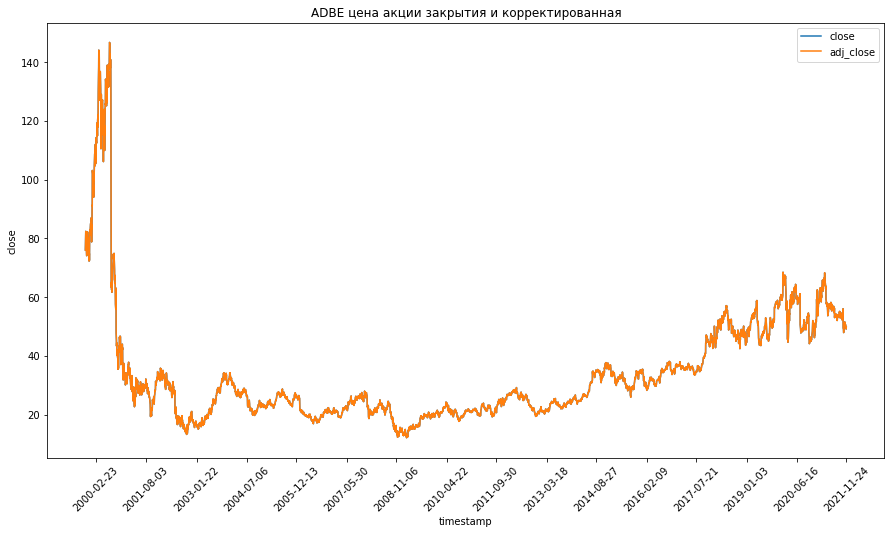

In [209]:
plt.figure(figsize=(15, 8))
sns.lineplot(data = intel[::-1], x = 'timestamp', y = 'close')
sns.lineplot(data = intel[::-1], x = 'timestamp', y = 'close')
plt.xticks(intel.timestamp[::365])
plt.xticks(rotation=45)
plt.legend(['close', 'adj_close'], loc = 'upper right')
plt.title('ADBE цена акции закрытия и корректированная')

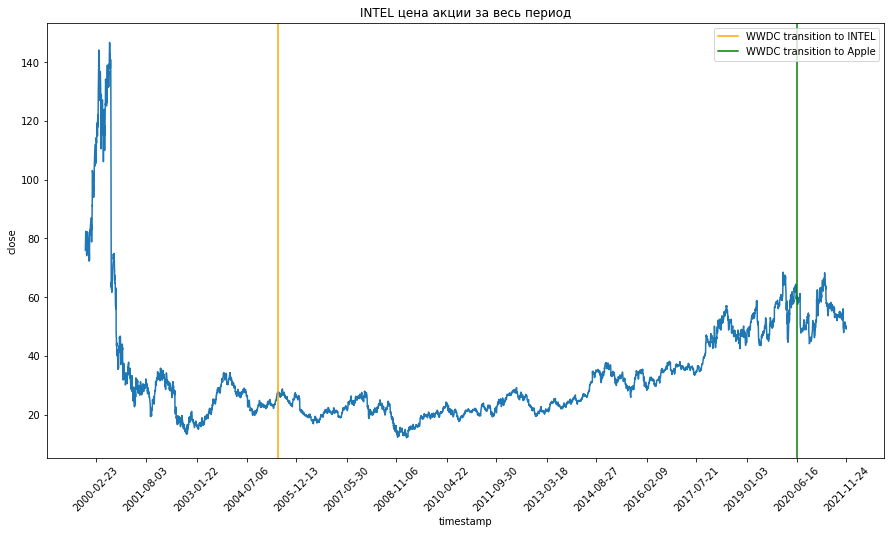

In [210]:
import datetime as dt

plt.figure(figsize=(15, 8))
sns.lineplot(data = intel[::-1], x = 'timestamp', y = 'close')
plt.xticks(intel.timestamp[::365])
plt.xticks(rotation=45)
plt.axvline(dt.datetime(2005, 6, 6), color = 'orange', label = 'WWDC transition to INTEL')
plt.axvline(dt.datetime(2020, 6, 22), color = 'green', label = 'WWDC transition to Apple')
plt.legend(loc = 'upper right')
plt.title('INTEL цена акции за весь период')
plt.savefig('intc.png')

In [211]:
short_intel = intel.query("timestamp>='2020-01-01'")

In [212]:
short_intel.timestamp = pd.to_datetime(short_intel.timestamp)

/Users/dmzakhar/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


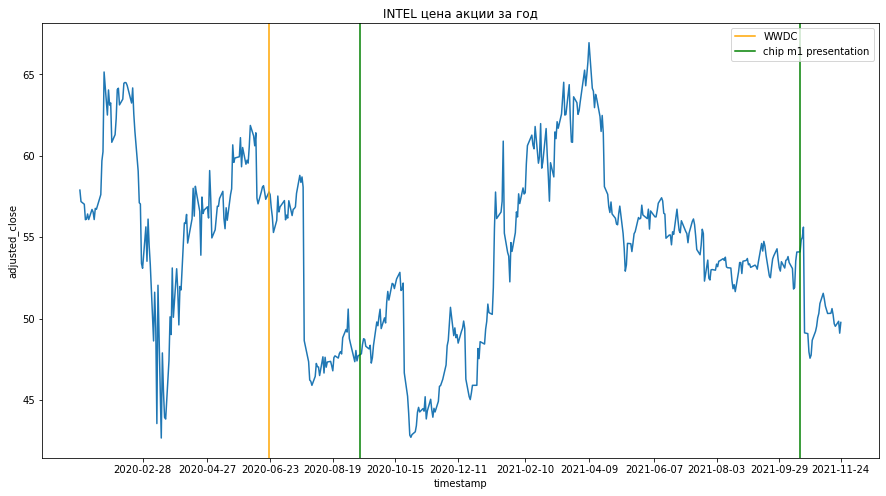

In [213]:
plt.figure(figsize=(15, 8))
sns.lineplot(data = short_intel[::-1], x = 'timestamp', y = 'adjusted_close')
plt.xticks(short_intel.timestamp[::40])
plt.axvline(dt.datetime(2020, 6, 22), color = 'orange', label = 'WWDC')
plt.axvline(dt.datetime(2020, 9, 13), color = 'green', label = 'chip m1 presentation')
plt.axvline(dt.datetime(2021, 10, 18), color = 'green')
plt.legend(loc = 'upper right')
plt.title('INTEL цена акции за год')
plt.savefig('intc_year.png')

In [214]:
from etna.datasets.tsdataset import TSDataset

In [215]:
original_df = intel

In [216]:
original_df = pd.DataFrame(pd.date_range(start=original_df.timestamp.min(),
                                         end=original_df.timestamp.max())[::-1],
                                        columns = ['timestamp'])
original_df = original_df.merge(intel[['timestamp', 'close']], how = 'left')

In [217]:
original_df = original_df.fillna(method='ffill')

In [218]:
original_df = original_df.rename(columns={'close': 'target'})
original_df["segment"] = "main"
original_df.head()

,timestamp,target,segment
0,2021-11-24,49.76,main
1,2021-11-23,49.10,main
2,2021-11-22,49.83,main
3,2021-11-21,49.83,main
4,2021-11-20,49.83,main


In [219]:
df = TSDataset.to_dataset(original_df)
df.head()

segment,main
feature,target
timestamp,
1999-11-01,76.00
1999-11-02,77.50
1999-11-03,79.75
1999-11-04,81.56
1999-11-05,82.38


In [220]:
from etna.transforms.imputation import TimeSeriesImputerTransform
d = TimeSeriesImputerTransform(strategy = 'forward_fill', window= 2)

In [221]:
ts = TSDataset(df, freq="D")

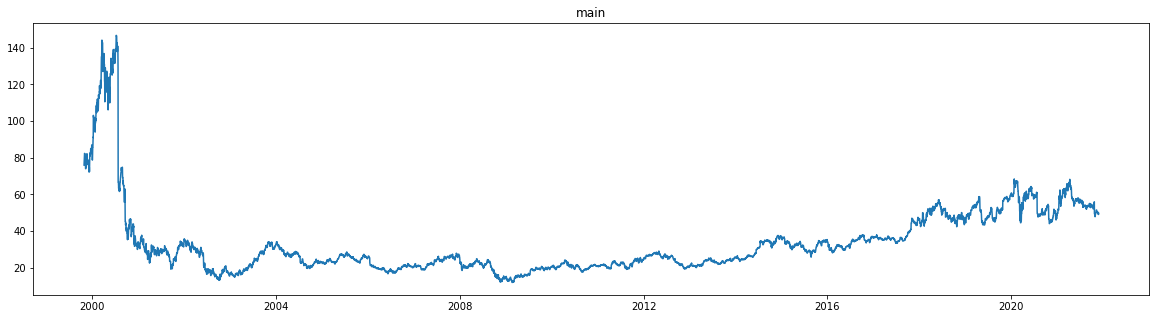

In [222]:
ts.plot()

In [223]:
train_ts, test_ts = ts.train_test_split(train_start='2015-07-24',
                                        train_end='2021-07-24',
                                        test_start='2021-07-25',
                                        test_end='2021-10-22')

In [224]:
HORIZON =90
from etna.models import NaiveModel

#Fit the model
model = NaiveModel(lag=20)
model.fit(train_ts)

#Make the forecast
future_ts = train_ts.make_future(HORIZON)
forecast_ts = model.forecast(future_ts)

In [225]:
from etna.metrics import SMAPE
smape = SMAPE()
smape(y_true=test_ts, y_pred=forecast_ts)

{'main': 3.6631858225683835}

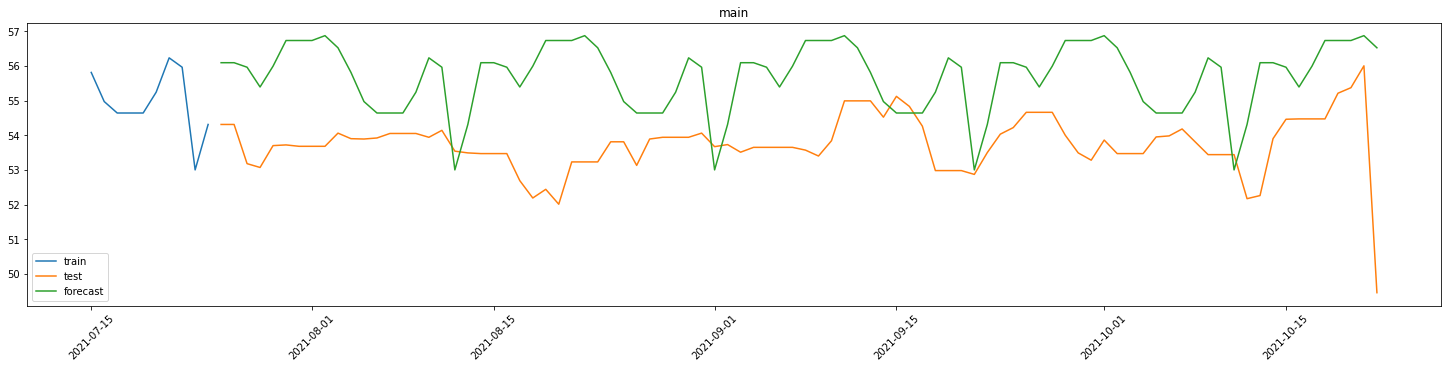

In [226]:
from etna.analysis import plot_forecast
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=10)


In [227]:
from etna.models import ProphetModel
HORIZON = 90
model = ProphetModel(interval_width= 0.8)
model.fit(train_ts)

#Make the forecast
future_ts = train_ts.make_future(HORIZON)
forecast_ts = model.forecast(future_ts, confidence_interval=True, interval_width=0.8)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [228]:
forecast_ts.columns

MultiIndex([('main',       'target'),
            ('main', 'target_lower'),
            ('main', 'target_upper')],
           names=['segment', 'feature'])

In [229]:
from etna.metrics import SMAPE
smape = SMAPE()

smape(y_true=test_ts, y_pred=forecast_ts)


{'main': 3.048683814924696}

In [230]:
from etna.analysis import plot_forecast


In [231]:
confidence_interval = pd.DataFrame(forecast_ts.loc[:,('main', 'target_lower'):('main', 'target_upper')].reset_index().to_numpy(), 
             columns = ['timestamp', 'target_lower', 'target_upper'])

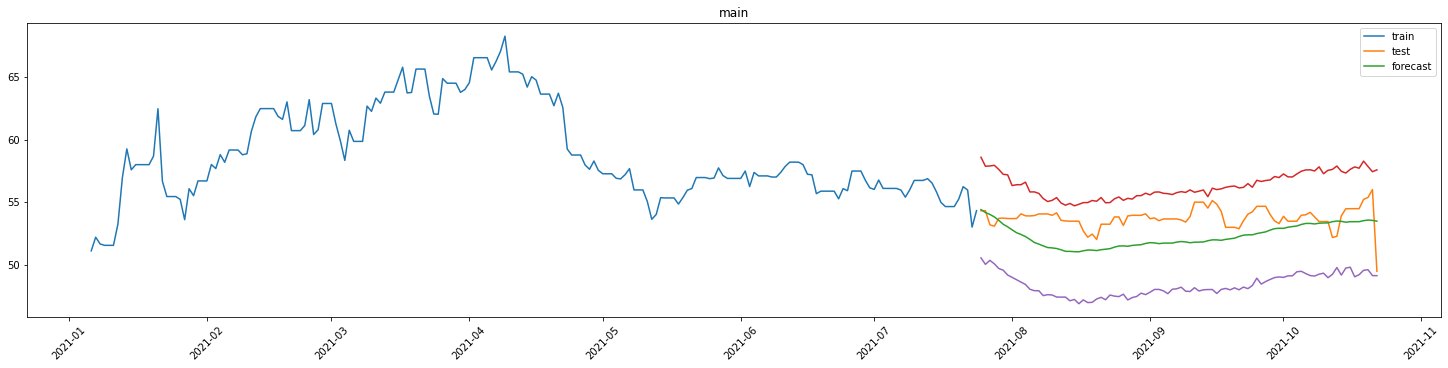

In [232]:
plot_forecast(forecast_ts, test_ts, train_ts, columns_num = 1, n_train_samples=200)
plt.plot(confidence_interval['timestamp'], confidence_interval['target_upper'])
plt.plot(confidence_interval['timestamp'], confidence_interval['target_lower'])

In [233]:
import copy
train_ts_new = copy.deepcopy(train_ts)

In [234]:
from etna.transforms.lags import LagTransform

lags = LagTransform(in_column="target", lags=list(range(1,1000)))
train_ts_new.fit_transform([lags])

In [236]:
from etna.models import CatBoostModelMultiSegment

model = CatBoostModelMultiSegment()
model.fit(train_ts_new)
future_ts = train_ts_new.make_future(HORIZON)
forecast_ts = model.forecast(future_ts)

In [237]:
from etna.metrics import SMAPE

smape = SMAPE()
smape(y_true=test_ts, y_pred=forecast_ts)

{'main': 10.629615493644176}

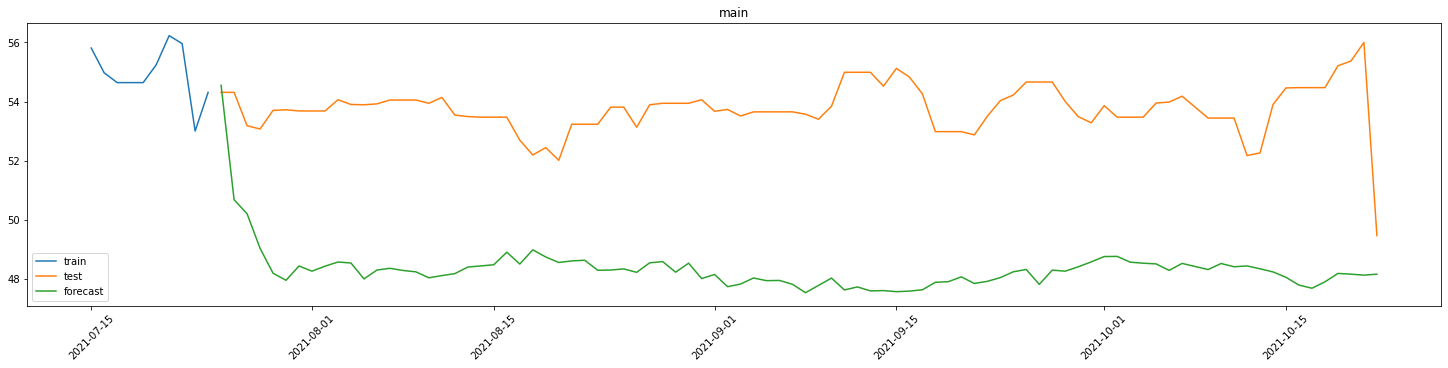

In [238]:
from etna.analysis import plot_forecast

train_ts.inverse_transform()
plot_forecast(forecast_ts, test_ts, train_ts_new, n_train_samples=10)

In [42]:
import pandas as pd
from etna.datasets.tsdataset import TSDataset
from etna.metrics import SMAPE
from etna.models import ProphetModel
from etna.analysis import plot_forecast
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

def load(tag):
    CSV_URL = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={}&outputsize=full&apikey=ZRMG7N7CVNEFA2RY&datatype=csv'.format(tag)
    company = pd.read_csv(CSV_URL)
    company.timestamp = pd.to_datetime(company.timestamp)
    return company

def preprocessing(company, train_len, horizon):
    original_df = company
    original_df = pd.DataFrame(pd.date_range(start=original_df.timestamp.min(),
                                         end=original_df.timestamp.max())[::-1],
                                        columns = ['timestamp'])
    original_df = original_df.merge(company[['timestamp', 'close']], how = 'left')
    original_df = original_df.fillna(method='ffill')
    original_df = original_df.rename(columns={'close': 'target'})
    original_df["segment"] = "main"
    df = TSDataset.to_dataset(original_df)
    ts = TSDataset(df, freq="D")
    
    HORIZON = horizon
    train_ts, test_ts = ts.train_test_split(train_start=str(original_df.timestamp.max()-timedelta(days=train_len)),
                                    train_end=str(original_df.timestamp.max()-timedelta(days=HORIZON)),
                                    test_start=str(original_df.timestamp.max()-timedelta(days=HORIZON-1)),
                                    test_end=str(original_df.timestamp.max()))
    
    return train_ts, test_ts

def predict(train_ts, test_ts, params, plot, horizon, nts = 100):
    HORIZON = horizon
    
    model = ProphetModel(**params)
    model.fit(train_ts)

    future_ts = train_ts.make_future(HORIZON)
    forecast_ts = model.forecast(future_ts, confidence_interval=True, interval_width=0.9)

    smape = SMAPE()
    smape = smape(y_true=test_ts, y_pred=forecast_ts)
    confidence_interval = pd.DataFrame(forecast_ts.loc[:,('main', 'target_lower'):('main', 'target_upper')].
                                       reset_index().to_numpy(), 
             columns = ['timestamp', 'target_lower', 'target_upper'])
    if plot:
        plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=nts)
        plt.plot(confidence_interval['timestamp'], confidence_interval['target_upper'])
        plt.plot(confidence_interval['timestamp'], confidence_interval['target_lower'])
    print('SMAPE:', smape['main'])
    print(params)
    return smape['main'], params

def complete(tag, params, train_len=365*3, horizon = 90, plot=False, nts = 200):
    critical_smape = 100
    best_params = {}
    company = load(tag)
    train_ts, test_ts = preprocessing(company, train_len, horizon = horizon)
    params_grid = params
    grid = ParameterGrid(params_grid)
    for p in grid:
        smape, params = predict(train_ts, test_ts, params = p, plot = plot, horizon = horizon, nts = nts)
        if smape < critical_smape:
            critical_smape = smape
            best_params = params
    print('----------------')
    print('best SMAPE = ', critical_smape)
    print('----------------')
    return best_params

In [ ]:
complete('ADBE', params = {'growth': ('linear','flat'),
                           'seasonality_mode':('additive','multiplicative'),
                           'n_changepoints': [50,100,200],
                           'changepoint_range':[0.8, 0.9]})

In [ ]:
complete('QCOM', {'seasonality_mode':('additive','multiplicative'),
                   'n_changepoints': [50,100,200],
                   'changepoint_range':[0.8, 0.9],
                   'uncertainty_samples':[20,30, 50]})

In [ ]:
complete('ZM', {'growth':['flat'],
                'yearly_seasonality':[True],
                  'seasonality_mode':['additive'],
                   'n_changepoints': [100, 200, 400, 600],
                   'changepoint_range':[0.2, 0.3, 0.4, 0.9],
                   'uncertainty_samples':[40,100, 400, 800]})

In [ ]:
complete('BIO', {'growth':['linear'],
                  'seasonality_mode':['additive'],
                   'n_changepoints': [100, 200, 400],
                   'changepoint_range':[0.2, 0.3, 0.4],
                   'uncertainty_samples':[40,100]})

In [ ]:
complete('PFE', {'growth':['linear'],
                  'seasonality_mode':['additive'],
                   'n_changepoints': [200, 400, 600, 800],
                   'changepoint_range':[0.3],
                   'uncertainty_samples':[100, 300, 800]})

In [ ]:
complete('CSV', params = {'growth':['linear'],
                  'seasonality_mode':['additive'], 
                   'n_changepoints': [20, 40, 60, 100],
                   'changepoint_range':[0.2, 0.3, 0.4],
                   'uncertainty_samples':[40,100]}, plot = True)

#### QCOM
{'main': 11.310899258382024}
{'changepoint_range': 0.8, 'n_changepoints': 80, 'uncertainty_samples': 20}

#### ADBE,
{'main': 4.426402603073118}
{'changepoint_range': 0.8, 'growth': 'linear', 'n_changepoints': 100, 'seasonality_mode': 'additive'}

#### ZM
{'main': 19.51835658528924}
{'growth': 'flat'}

#### BIO
{'main': 6.260330012596937}
{'changepoint_range': 0.3, 'growth': 'linear', 'n_changepoints': 100, 'seasonality_mode': 'additive', 'uncertainty_samples': 40}

#### PFE
{'main': 15.217319349135877}
{'changepoint_range': 0.3, 'growth': 'linear', 'n_changepoints': 400, 'seasonality_mode': 'additive', 'uncertainty_samples': 100}

#### CVS
{'main': 15.488949962933587}
{'changepoint_range': 0.4, 'growth': 'linear', 'n_changepoints': 20, 'seasonality_mode': 'additive', 'uncertainty_samples': 40}

UCITS ETF
FXFA ETF

EVR
MAGN
PLZL

JPY

ADBE, ZM, BIO, PFE, CVS
#Qualcomm, Adobe, Zoom, Bio-Rad Laboratories Inc, Pfizer, CVS Health Corporation, FinEx Акции компаний IT-сектора США, FinEx Облигаций развитых рынков, Evraz,MMK,Polyus, Иена,Турецкая лира

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SMAPE: 10.653911072395326
{'changepoint_range': 0.8, 'n_changepoints': 80, 'uncertainty_samples': 20}
----------------
best SMAPE =  10.653911072395326
----------------


{'changepoint_range': 0.8, 'n_changepoints': 80, 'uncertainty_samples': 20}

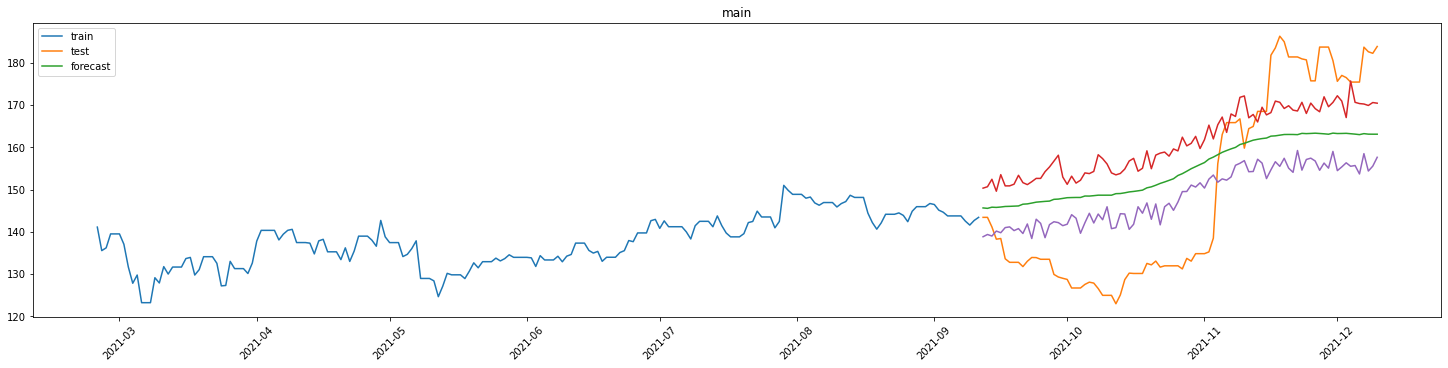

In [34]:
complete('QCOM', params = {'changepoint_range': [0.8],
                  'n_changepoints': [80],
                  'uncertainty_samples': [20]}, plot = True)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SMAPE: 7.638140237677447
{'changepoint_range': 0.8, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
----------------
best SMAPE =  7.638140237677447
----------------


{'changepoint_range': 0.8,
 'n_changepoints': 100,
 'seasonality_mode': 'additive'}

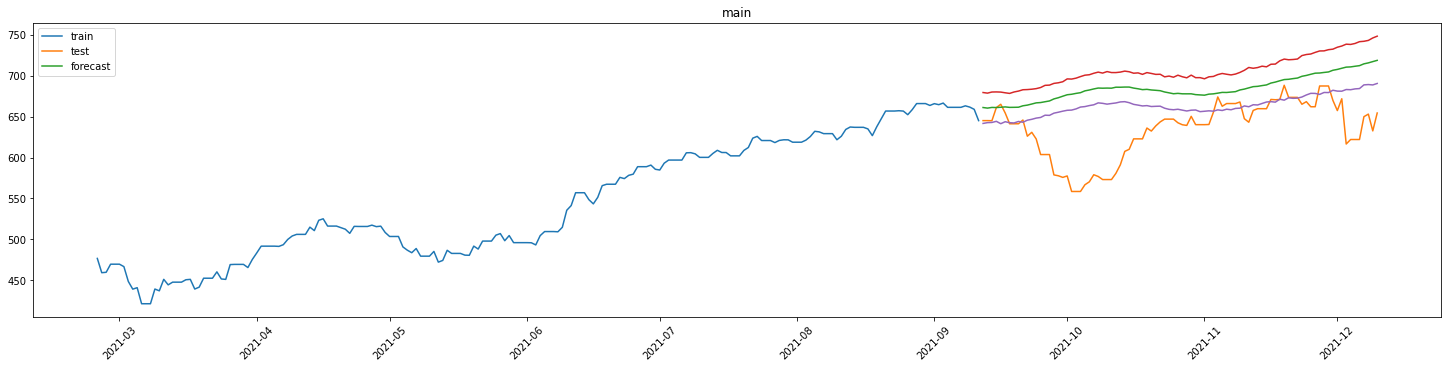

In [35]:
complete('ADBE', params = {'changepoint_range': [0.8],
                           'n_changepoints': [100],
                           'seasonality_mode': ['additive']}, plot = True)

In [ ]:
complete('ZM', train_len= 180, params = {}, plot = True)

In [ ]:
complete('PFE', train_len= 300, params = {'changepoint_range': [0.1],
                         'growth': ['linear'],
                          'n_changepoints': [100],
                         'seasonality_mode': ['additive'],
                         'uncertainty_samples': [40]}, plot = True, nts = 100)

In [ ]:
complete('CVS', train_len= 365, params = {'changepoint_range': [0.4],
                          'growth': ['linear'],
                          'n_changepoints': [20],
                          'seasonality_mode': ['multiplicative'],
                          'uncertainty_samples': [40]}, plot = True, nts = 100)


## Возможности для исследовния бибилотеки Etna

In [441]:
tag = 'CVS'
CSV_URL = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={}&outputsize=full&apikey=ZRMG7N7CVNEFA2RY&datatype=csv'.format(tag)
company = pd.read_csv(CSV_URL)
company.timestamp = pd.to_datetime(company.timestamp)

In [442]:
original_df = company
original_df = pd.DataFrame(pd.date_range(start=original_df.timestamp.min(),
                                     end=original_df.timestamp.max())[::-1],
                                    columns = ['timestamp'])
original_df = original_df.merge(company[['timestamp', 'close']], how = 'left')
original_df = original_df.fillna(method='ffill')
original_df = original_df.rename(columns={'close': 'target'})
original_df["segment"] = "main"
df = TSDataset.to_dataset(original_df)
ts = TSDataset(df, freq="D")

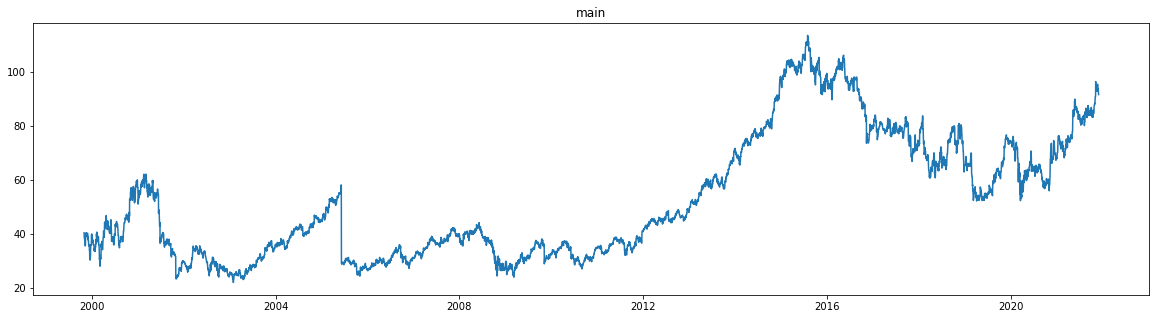

In [443]:
ts.plot()

In [242]:
from etna.analysis import (
    cross_corr_plot,
    distribution_plot,
    sample_pacf_plot,
    plot_correlation_matrix
)


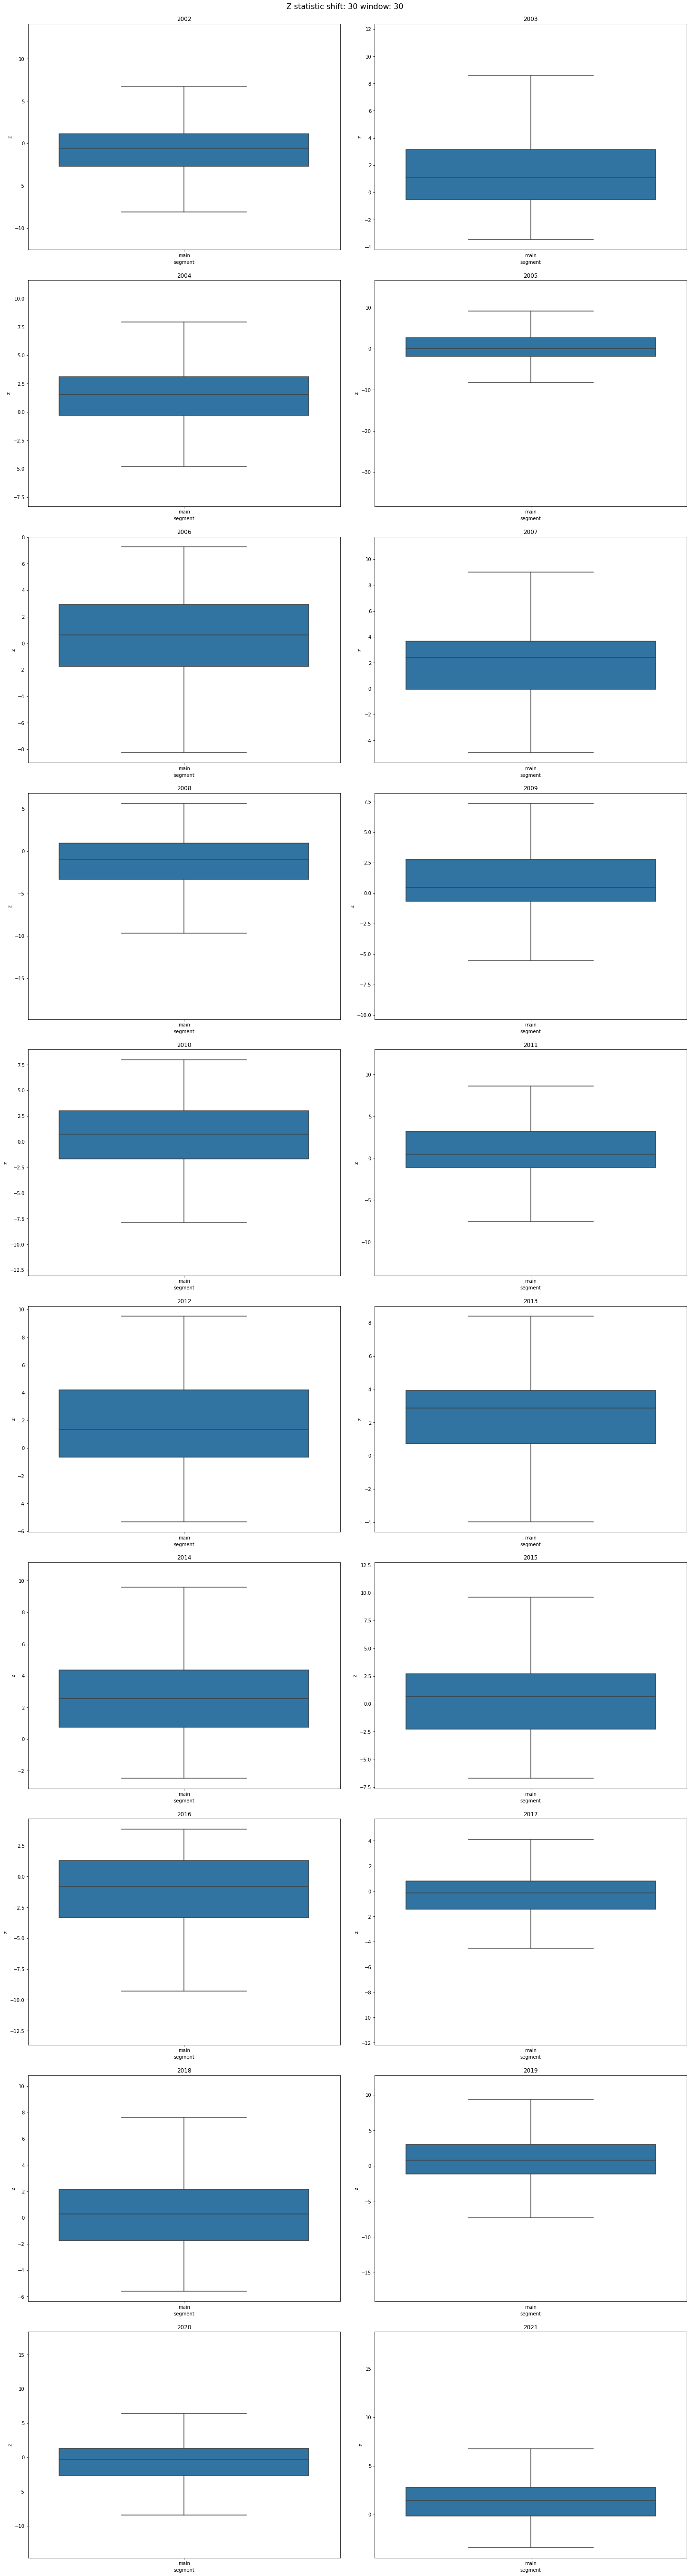

In [243]:
distribution_plot(ts, freq="1Y")

### Выбросы
#### Медианный метод
Чтобы получить выбросы точек с помощью метода медианы, нам нужно указать окно для подгонки медианной модели

In [244]:
from etna.analysis.outliers import get_anomalies_median, get_anomalies_density, get_sequence_anomalies
from etna.analysis import plot_anomalies

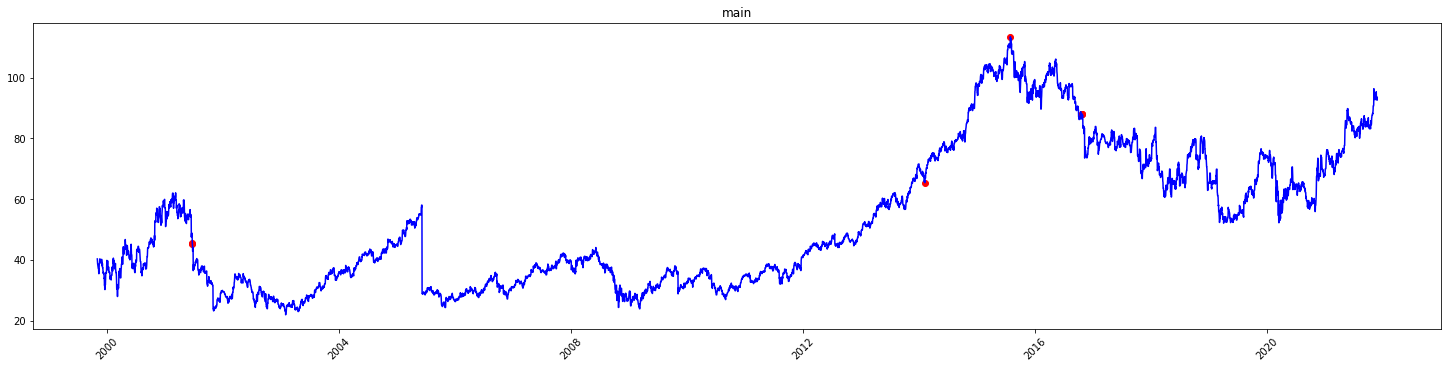

In [245]:
anomaly_dict = get_anomalies_median(ts, window_size=200)
plot_anomalies(ts, anomaly_dict)

#### Аномалии последовательности

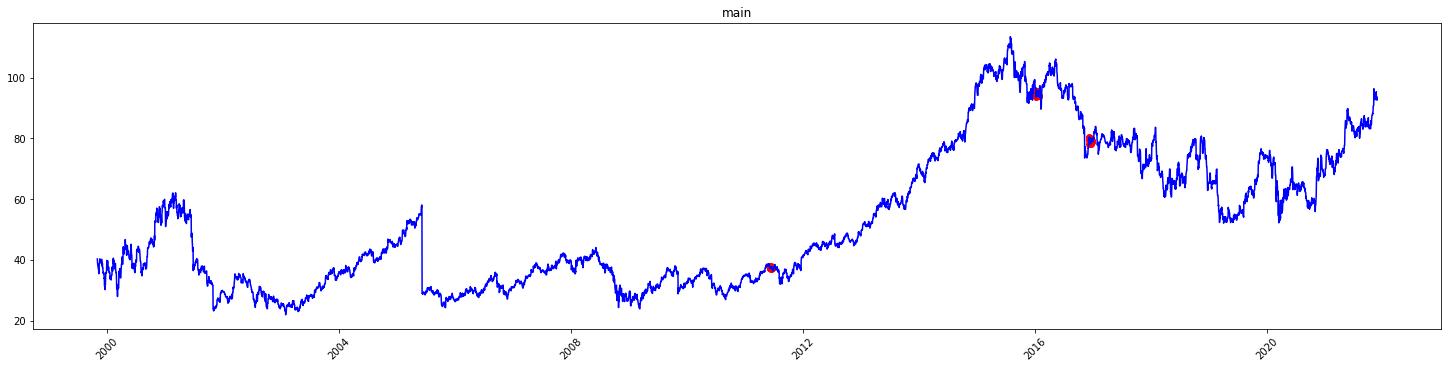

In [246]:
anomaly_seq_dict = get_sequence_anomalies(ts, num_anomalies = 3, anomaly_length = 20)
plot_anomalies(ts, anomaly_seq_dict)

### Фильтрация выбросов
### Обратные проверки
### Ансамблирование prophet+catboost+LSTM

### Backtest

In [444]:
df = df.tail(900)
ts = TSDataset(df, freq="D")

In [445]:
from etna.datasets.tsdataset import TSDataset
from etna.metrics import MAE
from etna.metrics import MSE
from etna.metrics import SMAPE
from etna.metrics.base import MetricAggregationMode
from etna.pipeline import Pipeline
from etna.model_selection.backtest import CrossValidationMode
from etna.model_selection.backtest import TimeSeriesCrossValidation
from etna.models.base import Model
from etna.models.prophet import ProphetModel
from etna.transforms.base import Transform
from etna.analysis.plotters import plot_backtest

In [459]:
horizon = 90 
model = ProphetModel(changepoint_range = 0.5,
                     daily_seasonality = True,
                     growth = 'linear',
                     n_changepoints = 300,
                     seasonality_mode = 'additive',
                     weekly_seasonality = True,
                     yearly_seasonality = False)
transforms = [] 

In [460]:
pipeline = Pipeline(model=model, transforms=transforms, horizon=horizon)

In [461]:
metrics_df, forecast_df, fold_info_df = pipeline.backtest(
    ts=ts, metrics=[MAE(), MSE(), SMAPE()]
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:prophet:n_changepoints greater than number of observations. Using 224.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s
INFO:prophet:n_changepoints greater than number of observations. Using 269.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   17.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.2s finished


In [470]:
metrics_df

,segment,MAE,MSE,SMAPE,fold_number
0,main,3.882186,31.854477,6.224788,0
0,main,8.967350,86.594714,13.279213,1
0,main,6.148547,61.842307,7.946016,2
0,main,2.737832,12.615361,3.325806,3
0,main,2.484286,8.260291,2.820257,4


In [466]:
forecast_df.head()

segment          main            
feature        target fold_number
timestamp                        
2020-09-03  60.883711           0
2020-09-04  60.973251           0
2020-09-05  60.875561           0
2020-09-06  60.823934           0
2020-09-07  60.772638           0

In [467]:
fold_info_df.head()

,train_start_time,train_end_time,test_start_time,test_end_time,fold_number
0,2019-06-11,2020-09-02,2020-09-03,2020-12-01,0
0,2019-06-11,2020-12-01,2020-12-02,2021-03-01,1
0,2019-06-11,2021-03-01,2021-03-02,2021-05-30,2
0,2019-06-11,2021-05-30,2021-05-31,2021-08-28,3
0,2019-06-11,2021-08-28,2021-08-29,2021-11-26,4


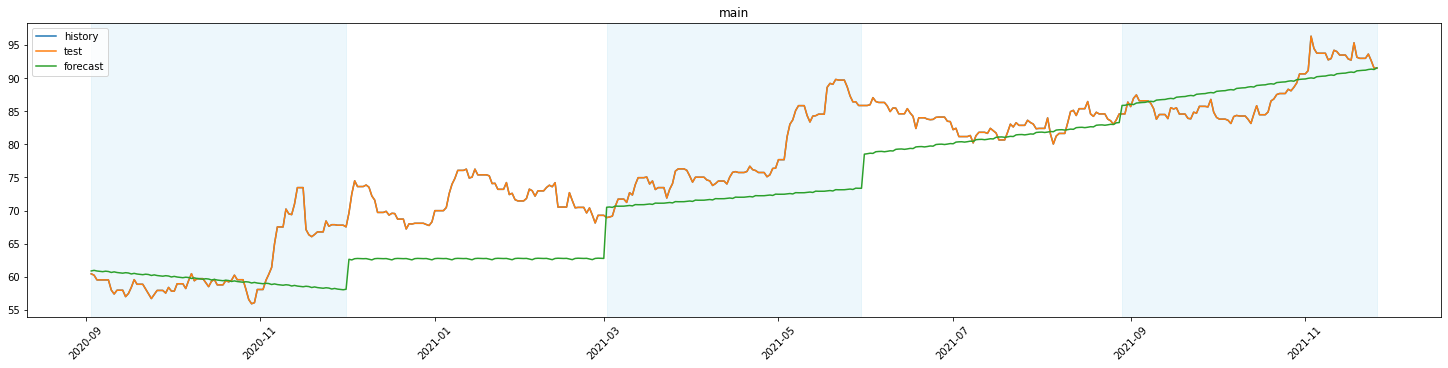

In [468]:
plot_backtest(forecast_df, ts)


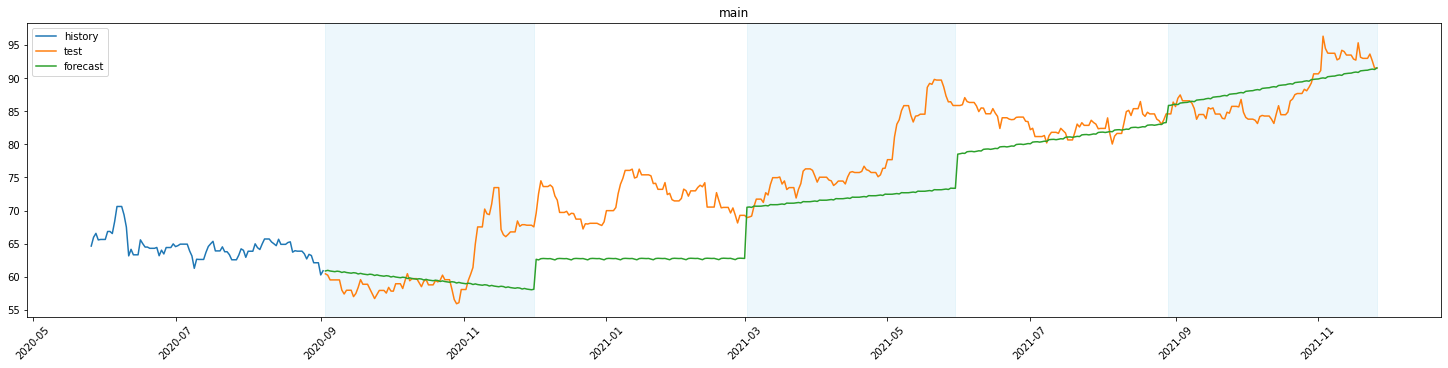

In [469]:
plot_backtest(forecast_df, ts, history_len=100)


## Автоматизация подбора гиперпараметров

In [51]:
best_params_ADBE = complete('ADBE', train_len=365*3,
                            horizon = 365,
                            params = {'growth': ('linear','flat'),
                           'seasonality_mode':('additive','multiplicative'),
                           'yearly_seasonality':(True, False),
                           'weekly_seasonality':(True, False),
                           'daily_seasonality': (True, False)})

SMAPE: 3.945069019880301
{'daily_seasonality': True, 'growth': 'linear', 'seasonality_mode': 'additive', 'weekly_seasonality': True, 'yearly_seasonality': True}
SMAPE: 8.93233011372082
{'daily_seasonality': True, 'growth': 'linear', 'seasonality_mode': 'additive', 'weekly_seasonality': True, 'yearly_seasonality': False}
SMAPE: 3.9336577980850858
{'daily_seasonality': True, 'growth': 'linear', 'seasonality_mode': 'additive', 'weekly_seasonality': False, 'yearly_seasonality': True}
SMAPE: 9.008353887680741
{'daily_seasonality': True, 'growth': 'linear', 'seasonality_mode': 'additive', 'weekly_seasonality': False, 'yearly_seasonality': False}
SMAPE: 24.567474295679062
{'daily_seasonality': True, 'growth': 'linear', 'seasonality_mode': 'multiplicative', 'weekly_seasonality': True, 'yearly_seasonality': True}
SMAPE: 9.624992906110995
{'daily_seasonality': True, 'growth': 'linear', 'seasonality_mode': 'multiplicative', 'weekly_seasonality': True, 'yearly_seasonality': False}
SMAPE: 25.264308

In [5]:
def reorganization(dict):
    for i in dict.items():
        dict[i[0]] = [i[1]]

In [428]:
reorganization(best_params_ADBE)

{'daily_seasonality': [False],
 'growth': ['linear'],
 'seasonality_mode': ['additive'],
 'weekly_seasonality': [True],
 'yearly_seasonality': [True]}

In [31]:
complete('ADBE', params = {**best_params_ADBE,
                           'n_changepoints': [i for i in range(50,400,50)],
                           'changepoint_range':[i for i in np.arange(0.5,0.9,0.1)]})

NameError: name 'best_params_ADBE' is not defined

In [9]:
def double_selection_hyperparameters(tag):
    best_params = complete(tag, params = {'growth': ('linear','flat'),
                           'seasonality_mode':('additive','multiplicative'),
                           'yearly_seasonality':(True, False),
                           'weekly_seasonality':(True, False),
                           'daily_seasonality': (True, False)})
    reorganization(best_params)
    final_params = complete(tag, params = {**best_params,
                           'n_changepoints': [i for i in range(50,400,50)],
                           'changepoint_range':[i for i in np.arange(0.5,0.9,0.1)]})
    return final_params

In [28]:
final_params_CVS = double_selection_hyperparameters('CVS')

SMAPE: 3.1118048195489485
{'daily_seasonality': True, 'growth': 'linear', 'seasonality_mode': 'additive', 'weekly_seasonality': True, 'yearly_seasonality': True}
SMAPE: 3.287336692876037
{'daily_seasonality': True, 'growth': 'linear', 'seasonality_mode': 'additive', 'weekly_seasonality': True, 'yearly_seasonality': False}
SMAPE: 3.1553543930654024
{'daily_seasonality': True, 'growth': 'linear', 'seasonality_mode': 'additive', 'weekly_seasonality': False, 'yearly_seasonality': True}
SMAPE: 3.306656808677727
{'daily_seasonality': True, 'growth': 'linear', 'seasonality_mode': 'additive', 'weekly_seasonality': False, 'yearly_seasonality': False}
SMAPE: 6.17649237323247
{'daily_seasonality': True, 'growth': 'linear', 'seasonality_mode': 'multiplicative', 'weekly_seasonality': True, 'yearly_seasonality': True}
SMAPE: 3.729225804751615
{'daily_seasonality': True, 'growth': 'linear', 'seasonality_mode': 'multiplicative', 'weekly_seasonality': True, 'yearly_seasonality': False}
SMAPE: 6.0457497

SMAPE: 3.000199297565671
{'changepoint_range': 0.7, 'daily_seasonality': True, 'growth': 'linear', 'n_changepoints': 50, 'seasonality_mode': 'additive', 'weekly_seasonality': True, 'yearly_seasonality': True}
SMAPE: 3.0073297438622735
{'changepoint_range': 0.7, 'daily_seasonality': True, 'growth': 'linear', 'n_changepoints': 100, 'seasonality_mode': 'additive', 'weekly_seasonality': True, 'yearly_seasonality': True}
SMAPE: 3.0195350167693733
{'changepoint_range': 0.7, 'daily_seasonality': True, 'growth': 'linear', 'n_changepoints': 150, 'seasonality_mode': 'additive', 'weekly_seasonality': True, 'yearly_seasonality': True}
SMAPE: 2.9338703280472793
{'changepoint_range': 0.7, 'daily_seasonality': True, 'growth': 'linear', 'n_changepoints': 200, 'seasonality_mode': 'additive', 'weekly_seasonality': True, 'yearly_seasonality': True}
SMAPE: 2.9226871766351685
{'changepoint_range': 0.7, 'daily_seasonality': True, 'growth': 'linear', 'n_changepoints': 250, 'seasonality_mode': 'additive', 'we

In [29]:
reorganization(final_params_CVS)

SMAPE: 2.917894415184369
{'changepoint_range': 0.7, 'daily_seasonality': True, 'growth': 'linear', 'n_changepoints': 350, 'seasonality_mode': 'additive', 'weekly_seasonality': True, 'yearly_seasonality': True}
----------------
best SMAPE =  2.917894415184369
----------------


{'changepoint_range': 0.7,
 'daily_seasonality': True,
 'growth': 'linear',
 'n_changepoints': 350,
 'seasonality_mode': 'additive',
 'weekly_seasonality': True,
 'yearly_seasonality': True}

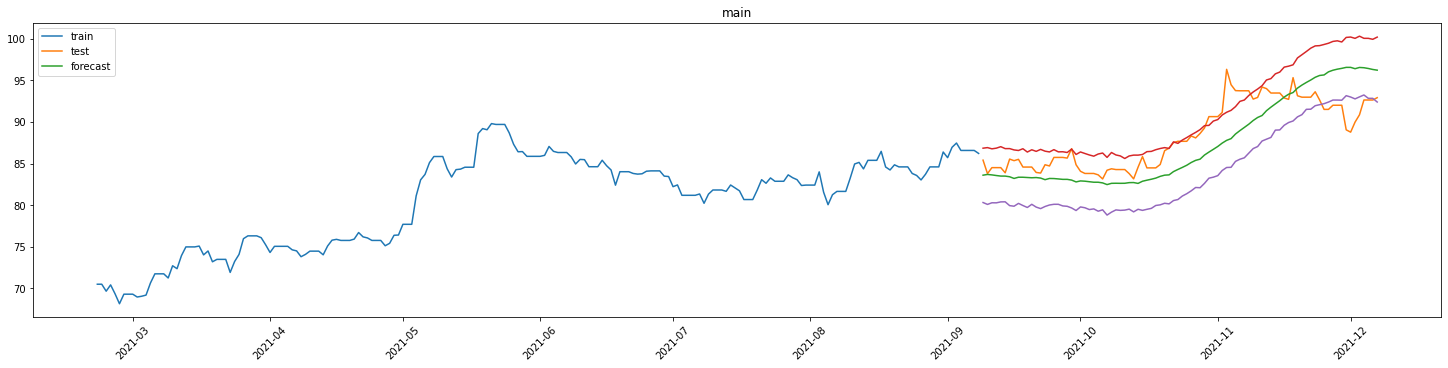

In [30]:
complete('CVS', params = final_params_CVS, plot = True)

In [472]:
#выше в разделе обратного тестирования оценили прогноз параметров на 5 фолдах

In [10]:
final_params_QCOM = double_selection_hyperparameters('QCOM')

SMAPE: 10.359741234405849
{'daily_seasonality': True, 'growth': 'linear', 'seasonality_mode': 'additive', 'weekly_seasonality': True, 'yearly_seasonality': True}
SMAPE: 12.109018529483526
{'daily_seasonality': True, 'growth': 'linear', 'seasonality_mode': 'additive', 'weekly_seasonality': True, 'yearly_seasonality': False}
SMAPE: 10.342168731525483
{'daily_seasonality': True, 'growth': 'linear', 'seasonality_mode': 'additive', 'weekly_seasonality': False, 'yearly_seasonality': True}
SMAPE: 12.114810676373137
{'daily_seasonality': True, 'growth': 'linear', 'seasonality_mode': 'additive', 'weekly_seasonality': False, 'yearly_seasonality': False}
SMAPE: 7.795300403932545
{'daily_seasonality': True, 'growth': 'linear', 'seasonality_mode': 'multiplicative', 'weekly_seasonality': True, 'yearly_seasonality': True}
SMAPE: 12.134093607448582
{'daily_seasonality': True, 'growth': 'linear', 'seasonality_mode': 'multiplicative', 'weekly_seasonality': True, 'yearly_seasonality': False}
SMAPE: 7.872

SMAPE: 6.435369945669993
{'changepoint_range': 0.7, 'daily_seasonality': True, 'growth': 'linear', 'n_changepoints': 50, 'seasonality_mode': 'multiplicative', 'weekly_seasonality': True, 'yearly_seasonality': True}
SMAPE: 6.3971551505445685
{'changepoint_range': 0.7, 'daily_seasonality': True, 'growth': 'linear', 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'weekly_seasonality': True, 'yearly_seasonality': True}
SMAPE: 6.4674197064195456
{'changepoint_range': 0.7, 'daily_seasonality': True, 'growth': 'linear', 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'weekly_seasonality': True, 'yearly_seasonality': True}
SMAPE: 6.477445145165713
{'changepoint_range': 0.7, 'daily_seasonality': True, 'growth': 'linear', 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'weekly_seasonality': True, 'yearly_seasonality': True}
SMAPE: 6.4025280779837015
{'changepoint_range': 0.7, 'daily_seasonality': True, 'growth': 'linear', 'n_changepoints': 250, 'seasonality

In [11]:
final_params_QCOM

{'changepoint_range': 0.7,
 'daily_seasonality': True,
 'growth': 'linear',
 'n_changepoints': 300,
 'seasonality_mode': 'multiplicative',
 'weekly_seasonality': True,
 'yearly_seasonality': True}

In [14]:
reorganization(final_params_QCOM)

SMAPE: 6.196935688274319
{'changepoint_range': 0.7, 'daily_seasonality': True, 'growth': 'linear', 'n_changepoints': 300, 'seasonality_mode': 'multiplicative', 'weekly_seasonality': True, 'yearly_seasonality': True}
----------------
best SMAPE =  6.196935688274319
----------------


{'changepoint_range': 0.7,
 'daily_seasonality': True,
 'growth': 'linear',
 'n_changepoints': 300,
 'seasonality_mode': 'multiplicative',
 'weekly_seasonality': True,
 'yearly_seasonality': True}

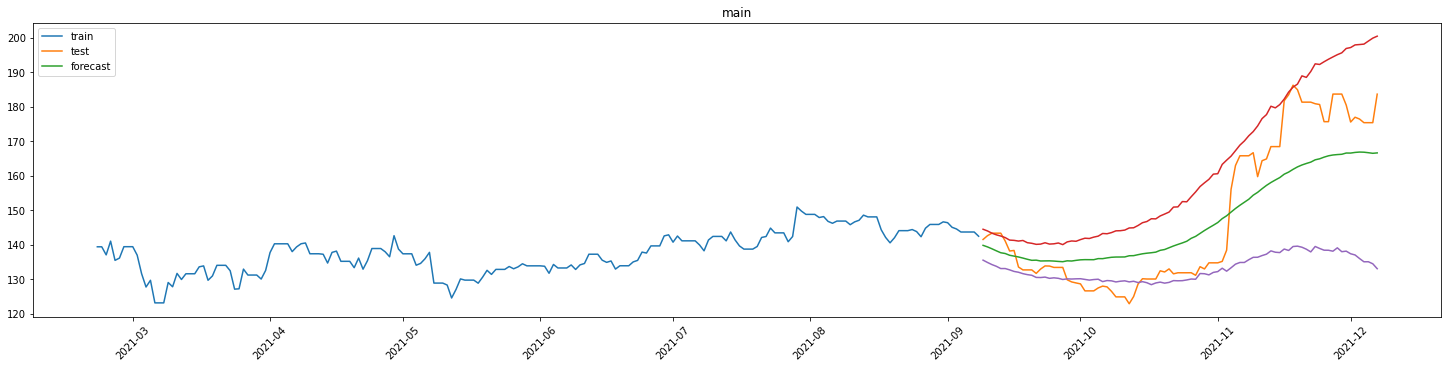

In [23]:
complete('QCOM', params = final_params_QCOM, plot = True)

In [24]:
final_params_ZM = double_selection_hyperparameters('ZM')

/Users/dmzakhar/opt/anaconda3/lib/python3.8/site-packages/etna/datasets/tsdataset.py:602: UserWarning: Min timestamp in df is 2019-04-18 00:00:00.
  warnings.warn(f"Min timestamp in df is {self.df.index.min()}.")


SMAPE: 32.167358155664715
{'daily_seasonality': True, 'growth': 'linear', 'seasonality_mode': 'additive', 'weekly_seasonality': True, 'yearly_seasonality': True}
SMAPE: 32.039580051722545
{'daily_seasonality': True, 'growth': 'linear', 'seasonality_mode': 'additive', 'weekly_seasonality': True, 'yearly_seasonality': False}
SMAPE: 33.24923607314464
{'daily_seasonality': True, 'growth': 'linear', 'seasonality_mode': 'additive', 'weekly_seasonality': False, 'yearly_seasonality': True}
SMAPE: 32.05985907626661
{'daily_seasonality': True, 'growth': 'linear', 'seasonality_mode': 'additive', 'weekly_seasonality': False, 'yearly_seasonality': False}
SMAPE: 25.337864237404823
{'daily_seasonality': True, 'growth': 'linear', 'seasonality_mode': 'multiplicative', 'weekly_seasonality': True, 'yearly_seasonality': True}
SMAPE: 37.13846469574253
{'daily_seasonality': True, 'growth': 'linear', 'seasonality_mode': 'multiplicative', 'weekly_seasonality': True, 'yearly_seasonality': False}
SMAPE: 25.5059

/Users/dmzakhar/opt/anaconda3/lib/python3.8/site-packages/etna/datasets/tsdataset.py:602: UserWarning: Min timestamp in df is 2019-04-18 00:00:00.
  warnings.warn(f"Min timestamp in df is {self.df.index.min()}.")


SMAPE: 9.185670977982213
{'changepoint_range': 0.5, 'daily_seasonality': False, 'growth': 'flat', 'n_changepoints': 50, 'seasonality_mode': 'additive', 'weekly_seasonality': False, 'yearly_seasonality': True}
SMAPE: 9.185670977982225
{'changepoint_range': 0.5, 'daily_seasonality': False, 'growth': 'flat', 'n_changepoints': 100, 'seasonality_mode': 'additive', 'weekly_seasonality': False, 'yearly_seasonality': True}
SMAPE: 9.185670977982213
{'changepoint_range': 0.5, 'daily_seasonality': False, 'growth': 'flat', 'n_changepoints': 150, 'seasonality_mode': 'additive', 'weekly_seasonality': False, 'yearly_seasonality': True}
SMAPE: 9.185670977982225
{'changepoint_range': 0.5, 'daily_seasonality': False, 'growth': 'flat', 'n_changepoints': 200, 'seasonality_mode': 'additive', 'weekly_seasonality': False, 'yearly_seasonality': True}
SMAPE: 9.185670977982213
{'changepoint_range': 0.5, 'daily_seasonality': False, 'growth': 'flat', 'n_changepoints': 250, 'seasonality_mode': 'additive', 'weekly_

In [25]:
reorganization(final_params_ZM)

/Users/dmzakhar/opt/anaconda3/lib/python3.8/site-packages/etna/datasets/tsdataset.py:602: UserWarning: Min timestamp in df is 2019-04-18 00:00:00.
  warnings.warn(f"Min timestamp in df is {self.df.index.min()}.")


SMAPE: 9.185670977982213
{'changepoint_range': 0.5, 'daily_seasonality': False, 'growth': 'flat', 'n_changepoints': 50, 'seasonality_mode': 'additive', 'weekly_seasonality': False, 'yearly_seasonality': True}
----------------
best SMAPE =  9.185670977982213
----------------


{'changepoint_range': 0.5,
 'daily_seasonality': False,
 'growth': 'flat',
 'n_changepoints': 50,
 'seasonality_mode': 'additive',
 'weekly_seasonality': False,
 'yearly_seasonality': True}

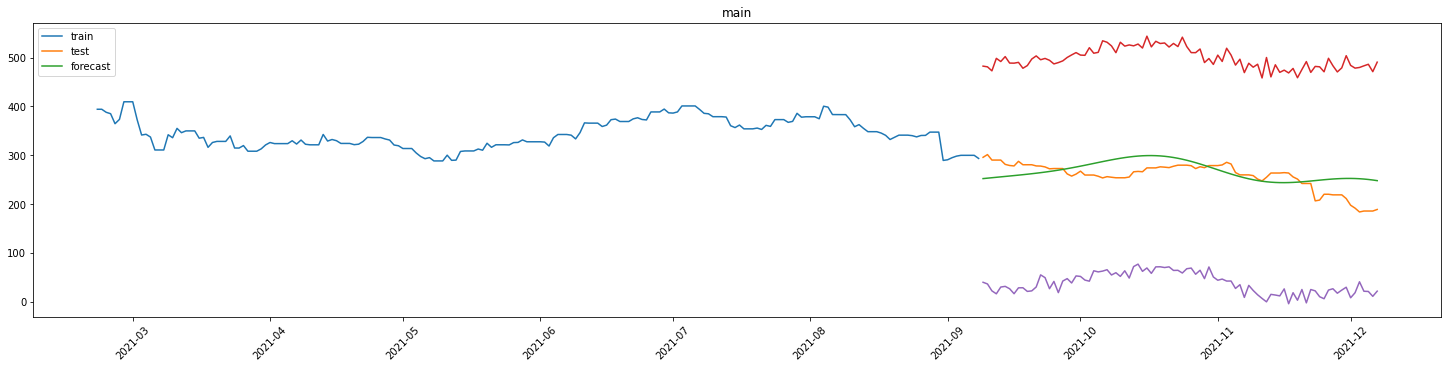

In [26]:
complete('ZM', params = final_params_ZM, plot = True)